![alt text](https://camo.githubusercontent.com/d464ca86de08d7173fcccc38ec0c840a6da02cea/68747470733a2f2f656e676d726b2e636f6d2f77702d636f6e74656e742f75706c6f6164732f323031382f30392f4c654e65745f4f726967696e616c5f496d6167652e6a7067)

![alt text](https://camo.githubusercontent.com/9028f39092178a1b65f243eb8b471ebd84920cec/68747470733a2f2f656e676d726b2e636f6d2f77702d636f6e74656e742f75706c6f6164732f323031382f30392f4c654e45745f53756d6d6172795f5461626c652e6a7067)

In [0]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
import torchvision.datasets

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
len(y_train), len(y_test)

(60000, 10000)

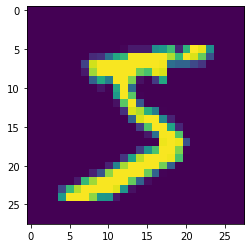

tensor(5)


In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [0]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [8]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [0]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh', # tanh  или relu
                 pooling='avg',     # avg  или max
                 conv_size=5,       #  свертка 5x5 или две 3x3
                 use_batch_norm=False):  # будет ли батч-нормализация
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
        
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=1, out_channels=6, kernel_size=5, padding=2)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=1, out_channels=6, kernel_size=3, padding=1)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=1)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
       
        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function
    
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [14]:
# Тренировка
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    # Батч-нормализация выполняется при forward - поэтому нужно писать net.eval() для прода
    # Чтоб в батч-норм слое параметры не изменялись при уже работающей сети
    # net.train()
    # net.eval()

    for epoch in range(10):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()  # сеть находится в состоянии тренировки

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch) 

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        net.eval()  # сеть находится в состоянии оценки
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        print(accuracy)
    print('---------------')
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}

# Тренируем разные сети
accuracies['tanh'], losses['tanh'] = \
    train(LeNet5(activation='tanh', conv_size=5),
          X_train, y_train, X_test, y_test)

accuracies['relu'], losses['relu'] = \
    train(LeNet5(activation='relu', conv_size=5),
          X_train, y_train, X_test, y_test)

accuracies['relu_3'], losses['relu_3'] = \
    train(LeNet5(activation='relu', conv_size=3),
          X_train, y_train, X_test, y_test)

accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max'), 
          X_train, y_train, X_test, y_test)

accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), 
          X_train, y_train, X_test, y_test)

tensor(0.9737)
tensor(0.9827)
tensor(0.9861)
tensor(0.9860)
tensor(0.9877)
tensor(0.9884)
tensor(0.9861)
tensor(0.9877)
tensor(0.9853)
tensor(0.9880)
---------------
tensor(0.9793)
tensor(0.9860)
tensor(0.9875)
tensor(0.9875)
tensor(0.9893)
tensor(0.9897)
tensor(0.9904)
tensor(0.9887)
tensor(0.9897)
tensor(0.9897)
---------------
tensor(0.9805)
tensor(0.9845)
tensor(0.9857)
tensor(0.9865)
tensor(0.9885)
tensor(0.9856)
tensor(0.9879)
tensor(0.9896)
tensor(0.9893)
tensor(0.9892)
---------------
tensor(0.9835)
tensor(0.9832)
tensor(0.9827)
tensor(0.9886)
tensor(0.9889)
tensor(0.9883)
tensor(0.9868)
tensor(0.9825)
tensor(0.9885)
tensor(0.9894)
---------------
tensor(0.9822)
tensor(0.9875)
tensor(0.9867)
tensor(0.9891)
tensor(0.9890)
tensor(0.9901)
tensor(0.9897)
tensor(0.9895)
tensor(0.9893)
tensor(0.9906)
---------------


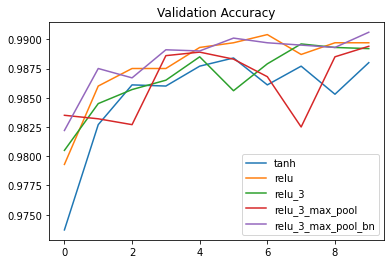

In [15]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

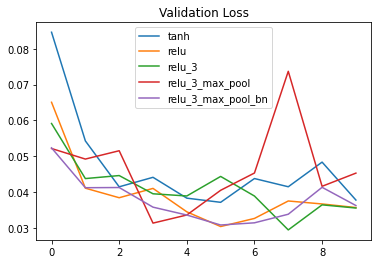

In [16]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

In [22]:
# ПОсмотрим какая функция активации меньше всего тушит градиент
import torch
import numpy as np
from torch.nn import *

seed = int(11)
np.random.seed(seed)
torch.manual_seed(seed)

NUMBER_OF_EXPERIMENTS = 200

class SimpleNet(torch.nn.Module):
    def __init__(self, activation):
        super().__init__()

        self.activation = activation
        self.fc1 = torch.nn.Linear(1, 1, bias=False)  # one neuron without bias
        self.fc1.weight.data.fill_(1.)  # init weight with 1
        self.fc2 = torch.nn.Linear(1, 1, bias=False)
        self.fc2.weight.data.fill_(1.)
        self.fc3 = torch.nn.Linear(1, 1, bias=False)
        self.fc3.weight.data.fill_(1.)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        return x

    def get_fc1_grad_abs_value(self):
        return torch.abs(self.fc1.weight.grad)

def get_fc1_grad_abs_value(net, x):
    output = net.forward(x)
    output.backward()  # no loss function. Pretending that we want to minimize output
                       # In our case output is scalar, so we can calculate backward
    fc1_grad = net.get_fc1_grad_abs_value().item()
    net.zero_grad()
    return fc1_grad

activation = [ELU(), Hardtanh(), LeakyReLU(), LogSigmoid(), PReLU(), ReLU(), ReLU6(), RReLU(), SELU(), CELU(), Sigmoid(), Softplus(), Softshrink(), Softsign(), Tanh(), Tanhshrink(), Hardshrink()]

for a in activation:
    net = SimpleNet(activation=a)

    fc1_grads = []
    for x in torch.randn((NUMBER_OF_EXPERIMENTS, 1)):
        fc1_grads.append(get_fc1_grad_abs_value(net, x))

# Проверка осуществляется автоматически, вызовом функции:
    print(np.mean(fc1_grads), a)
# (раскомментируйте, если решаете задачу локально)


# Hardshrink - меньше всего тушит градиент

0.46825177246239036 ELU(alpha=1.0)
0.2953543031180743 Hardtanh(min_val=-1.0, max_val=1.0)
0.3869488415962411 LeakyReLU(negative_slope=0.01)
0.22678142257966102 LogSigmoid()
0.35629074233864233 PReLU(num_parameters=1)
0.39361816555727275 ReLU()
0.3758565194578841 ReLU6()
0.3941042095749435 RReLU(lower=0.125, upper=0.3333333333333333)
0.5512814357271418 SELU()
0.4496136348252185 CELU(alpha=1.0)
0.00696174914824951 Sigmoid()
0.2403151065611746 Softplus(beta=1, threshold=20)
0.24748901307582855 Softshrink(0.5)
0.06543945850222371 Softsign()
0.1605677444220055 Tanh()
0.024549292927610655 Tanhshrink()
0.7263762906193734 Hardshrink(0.5)
